# Astroturfing on Reddit: Comparing Reddit User Engagement across Fake, Factual, Corrective, and Regular News

## Motivation

The recent focus on fake news in Western democracies within social sciences has also given rise to the related notion of astroturfing. As defined by Zhang et al. (2013):

> "Online astroturfing refers to coordinated campaigns where messages supporting a specific agenda are distributed via the Internet. These messages employ deception to create the appearance of being generated by an independent entity."

In this perspective, astroturfing can be viewed as a mechanism that enables the initial spread of a fake news item on social media. By initially associating a fake news story with artificial user activity to mimic grassroots activity, the story may gather increased attention from regular users and achieve greater user engagement over the full duration of its lifespan. In this study, we will analyze whether the effect of a Reddit post's initial user engagement on total user engagement is dependent on the specific type of news story.

---

## Data

<img src="../output/data_diagram_final_annotated.png" width="400" align="center"/>

To construct the dataset, we collect 695,147,095 Reddit posts from [Pushshift](https://pushshift.io). This constitutes every submission made between January 2016 and April 2020. We also rely on [the ClaimReview Project](https://www.claimreviewproject.com), a collective of verified journalists and fact-checkers, to obtain structured reviews of news items by scraping 151,025 ClaimReviews from [Google Fact Check Explorer](https://toolbox.google.com/factcheck/explorer) spanning from January 2015 to October 2020.

Merging these two datasets, we obtain two collections of post-review pairs: One representing the Reddit posts that link to articles that have also been reviewed by fact checkers; and another representing the posts that link directly to the corrective review articles themselves.

Since not all reviews include a quantitative truthfulness score, we include only those pairs that are numerically scored as either fake or factual. In total, we obtain 4,696 posts linking to news articles, and 16,938 linking to review articles. Among the news articles, 1,571 claims were deemed true while 3,125 were proven false. Similarly, 4,190 reviews verfied the corresponding claim as true while 12,748 disproved the claim as false.

In [1]:
import sys
sys.path.insert(0, '../model')

from data_proc import load_raw_data, processData, transform_data, split_and_prep_data
from type_model import type_model, type_guide
from subreddit_model import subreddit_model, subreddit_guide
from complete_model import complete_model, complete_guide
from model_utils import get_y_pred, print_labeled_type_coefs
from inference import run_svi, plot_losses
from evaluation import (
    plot_predictions, plot_predictions_by_subreddit, plot_ppc_grid, plot_pp_hdi, plot_expectations,
    get_samples, evaluate, print_results
)

from ModelManager import ModelManager

First, we load in our data, unpack it, and process it for use in our models.

In [2]:
mm = ModelManager()

In [3]:
mm.load_data()

Now, we take a log transform of post-level comments in the first hour to reason about the magnitude of the number of comments rather than the number directly.

In [4]:
mm.transform_data()

Finally, we split our data into test and train sets. Note that we use the test data only for the final evaluation and comparison of our models.

In [5]:
mm.split_data(train_frac=0.7)

----

## Models

In modeling the total engagement of a Reddit post, we start with the simplest possible model first and gradually build on more levels. In the first section, we simply analyze the expected engagement by type to expose any explicit biases. 

### Expectations

As an initial check, we first calculate the expected total engagement of each type. The plot shows the distribution of total engagement over the posts in each content type group.

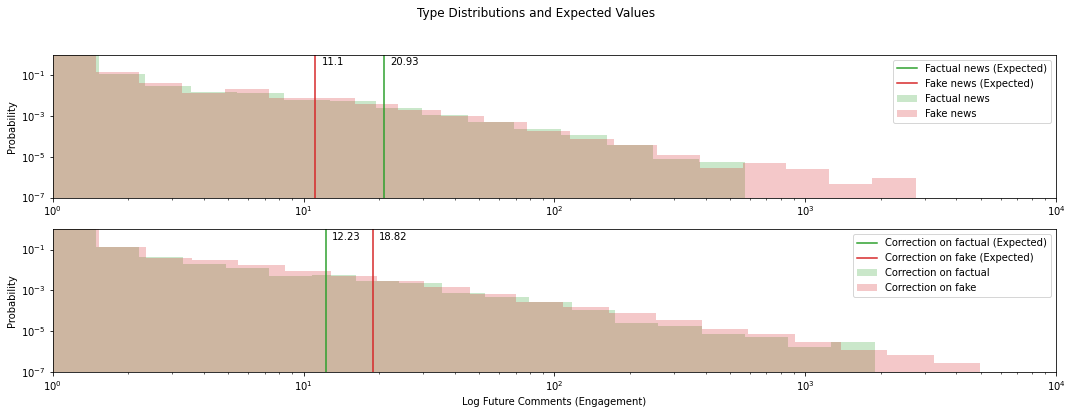

In [6]:
plot_expectations(mm.y, mm.p_types)

On expectation, factual news seem to generate the most comments, closely followed by corrective articles on fake news. Surprisingly, the least overall engagement seems to correspond to fake news articles.

To analyze these differences further, we will now turn to actual model building.

### Type level

In order to capture the difference in how different types of posts gain exposure, we next model each post as belonging to one of four "type" groups: 
1. Factual News
2. Fake News
3. Review of Factual News
4. Review of Fake News

Because each post belongs to exactly one of these type groups, we can depict this model graphically as shown below:

<img src="../output/model_type.png" width="400" align="center"/>

It is possible that due to astroturfing, we may see a disproportionately high number of total comments per first-hour comment, because the first hour may have artificially many comments (those from the astroturfers). However, the more successful the astroturfing was, the more total comments we would expect to see overall, potentially counteracting this first effect. Additionally, we may expect to see that corrections on fake news spark more debate than those on factual news.

Let's start by fitting our model.

In [7]:
type_losses = mm.run_svi("type", num_iters=100, lr=1e-2, zero_inflated=True)

Visualizing the losses, we build confidence that our model has converged.

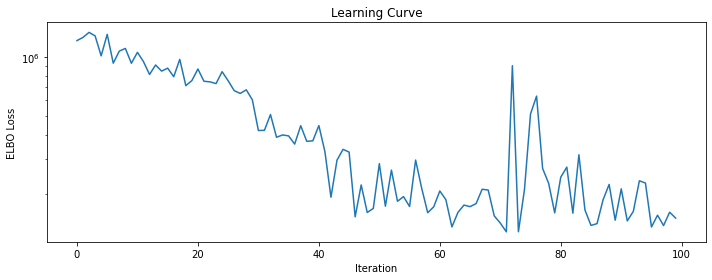

In [8]:
plot_losses(type_losses, filename="type_losses.png")

Below, we can see differences between groups. Note that among posts with no comments in the first hour, reviews of fake news seem to generate the most discussion. This may be due to the delayed effect of users having to more thoroughly review and reflect on the correction articles before commenting. Examining the growth rate of total engagement, it seems that fake news benefits the most from first-hour comments, suggesting astroturfing may be an effective strategy.

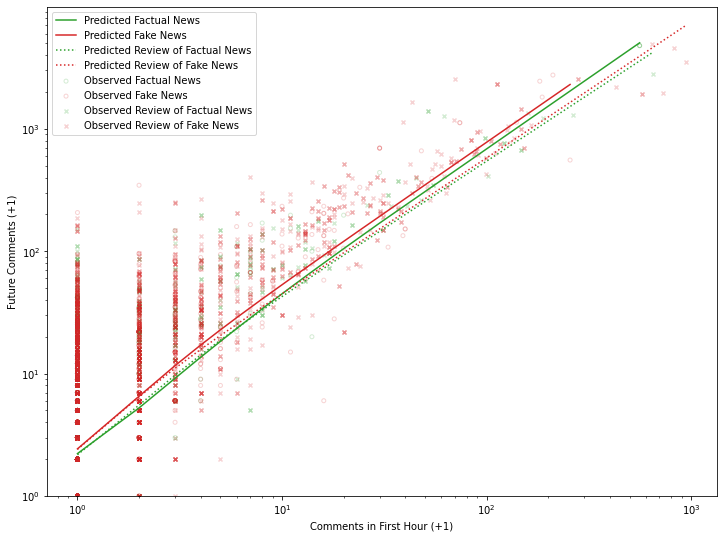

In [9]:
y_pred = mm.get_y_pred(use_train=True)
plot_predictions(mm.y_train, mm.original_p_data_train, mm.p_types_train, y_pred, filename="type_predictions.png")

Let's again take a closer look at our model's posterior predictive distribution.

In [10]:
posterior_predictive_samples = mm.get_samples("type", zero_inflated=True, num_samples=100)

In the Highest Density Interval (HDI) plot, we first notice that for large counts of inital comments, we see a tight band around the mean prediction. This may be explained through SVI's tendency to underestimate variance. Also, although the bands are tight in this range, the log scale of the plot exaggerates this effect visually.

Next, for smaller counts of initial comments, we notice a sharp drop in the lower band to include zero. This is a consequence of our choice of response variable distribution, the zero-inflated Poisson. To model this, we run two parallel regressions: one to predict the log-mean of the non-zero observations, and one to predict the probability of seeing zero additional comments after the first hour.

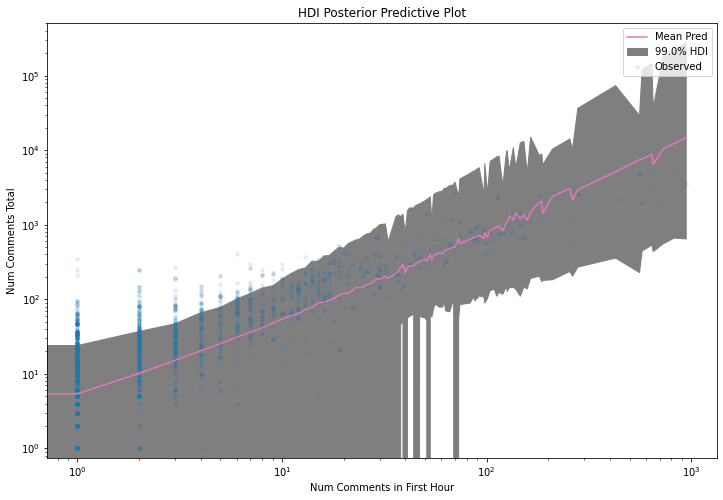

In [11]:
plot_pp_hdi(posterior_predictive_samples, mm.original_p_data_train, mm.y_train, filename="type_hdi.png")

Looking at our posterior predictive checks, we see that our model is able to balance between non-zero and zero predictions, yet for non-zero predictions, seems to overestimate. Finally, we overestimate the variance, possibly due to our zero-inflated model having a chance to predict zero future comments, creating a bimodal distribution for some range of first-hour comment counts.

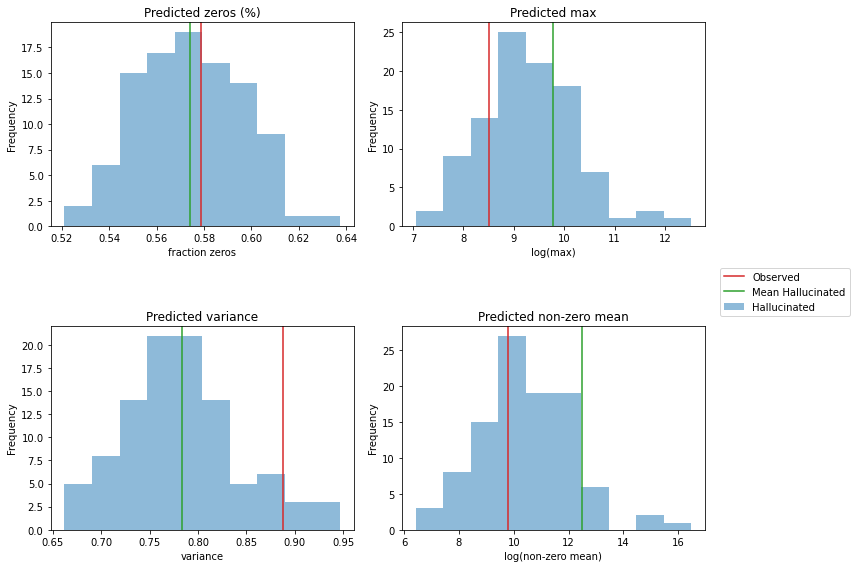

In [12]:
plot_ppc_grid(posterior_predictive_samples, mm.y_train, filename="type_ppc.png")

To evaluate the overall fit of our model to the training data, we calculate $R^2$ on both the original count data and the log transformed non-zero count data.

We note that although $R^2$ indicates that a relatively large fraction of the total variance is explained by the model, we are unable to explain as much variance in the magnitude of the non-zero counts through the $R^2$ log non-zero. This suggests that this model decently captures variation among high-magnitude observations, but struggles with the larger variation at lower-magnitude observations. Additionally, the traditional $R^2$ benefits from the model being able to predict zeros directly.

In [13]:
mm.evaluate(y_pred, partition='train', model='type')
print_results(mm.results, partition="train")

                    type
----------------  ------
R^2                 0.72
R^2 log non-zero    0.31


In [14]:
y_pred = mm.get_y_pred(use_train=False)
mm.evaluate(y_pred, partition='test', model='type')

### Subreddit level

We expect that posts submitted to subreddits with similar subscriber counts may exhibit similar effects on engagement. Here, we use the number of subscribers the subreddit had at the time of submission to partition the posts into evenly sized groups at the subreddit-level.

<img src="../output/model_subreddit.png" width="400" align="center"/>

Again, we first fit our model to the training data.

In [15]:
subreddit_losses = mm.run_svi("subreddit", num_iters=100, lr=1e-2, zero_inflated=True)

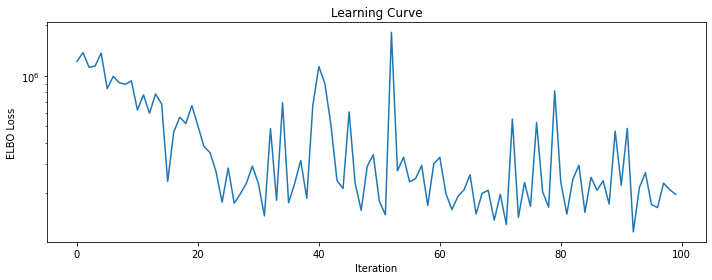

In [16]:
plot_losses(subreddit_losses, filename="subreddit_losses.png")

Checking the convergence of our model, we proceed to plot the predictions against the actual observations.

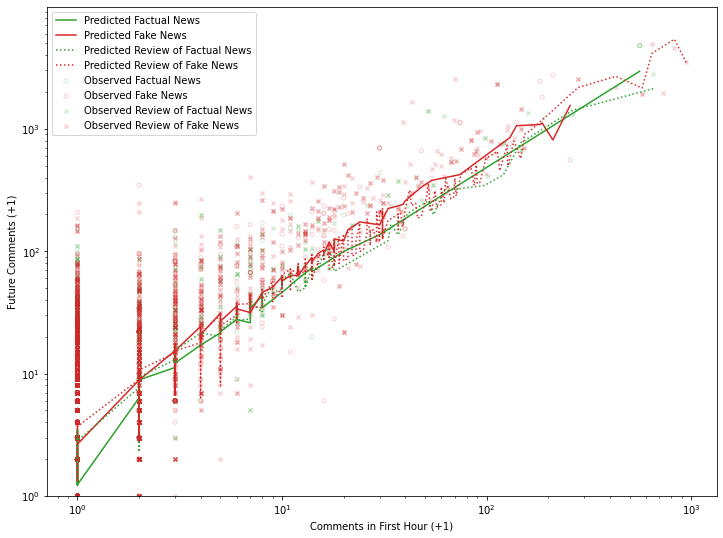

In [17]:
y_pred = mm.get_y_pred(use_train=True)
plot_predictions(mm.y_train, mm.original_p_data_train, mm.p_types_train, y_pred, filename="subreddit_predictions.png")

In [18]:
posterior_predictive_samples = mm.get_samples("subreddit", zero_inflated=True, num_samples=100)

Now, looking at the PPCs, we see dramatic improvement from the type-level. Our predicted fraction of zeros, maximum, and non-zero mean observations all lie well within the density of our hallucinated data. However, we still overestimate the variance.

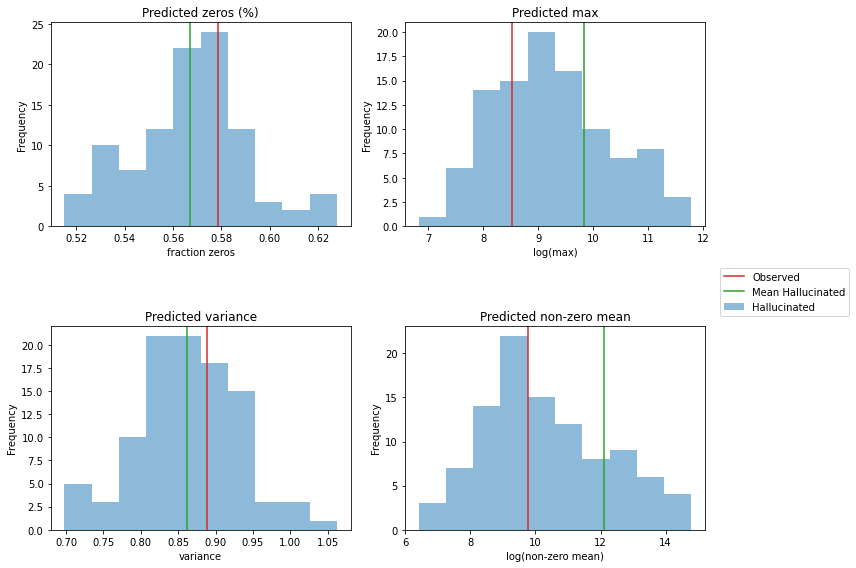

In [19]:
plot_ppc_grid(posterior_predictive_samples, mm.y_train, filename="subreddit_ppc.png")

Another way to visualize our model is by inspecting each of the 9 groups at the subreddit level. Here we can more clearly see how the groups may now exhibit different slopes and offsets.

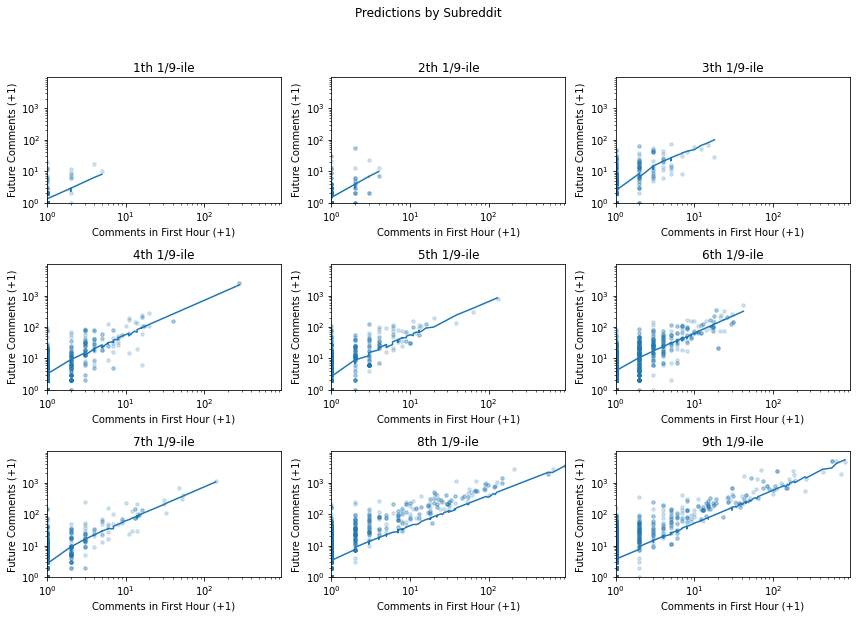

In [20]:
plot_predictions_by_subreddit(mm.y_train, mm.original_p_data_train, mm.p_subreddits_train, y_pred, filename="subreddit_by_subreddit.png")

Because this model captures subreddit-level variation, we witnessed improvements across all of our fit metrics.

In [21]:
mm.evaluate(y_pred, partition='train', model='subreddit')
print_results(mm.results, partition='train')

                    type    subreddit
----------------  ------  -----------
R^2                 0.72         0.76
R^2 log non-zero    0.31         0.47


In [22]:
y_pred = mm.get_y_pred(use_train=False)
mm.evaluate(y_pred, partition='test', model='subreddit')

### Complete model

In addition to belonging to a single type and subreddit, each post refers to a specific story. Depending on the author of the story and which countries the story is relevant to, we will model the story-level variation. Note that multiple types may link to a single story, giving us this model:

<img src="../output/model_complete.png" width="400" align="center"/>

In [23]:
complete_losses = mm.run_svi("complete", num_iters=100, lr=1e-2, zero_inflated=True)

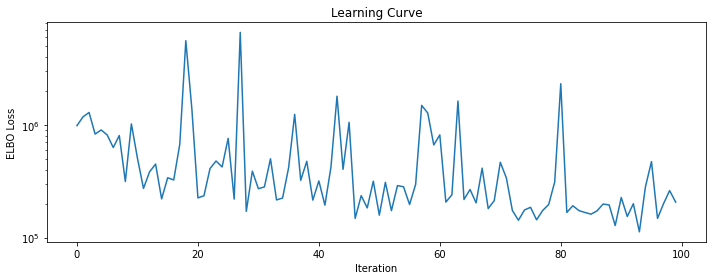

In [24]:
plot_losses(complete_losses, filename="complete_losses.png")

Again, our SVI converges.

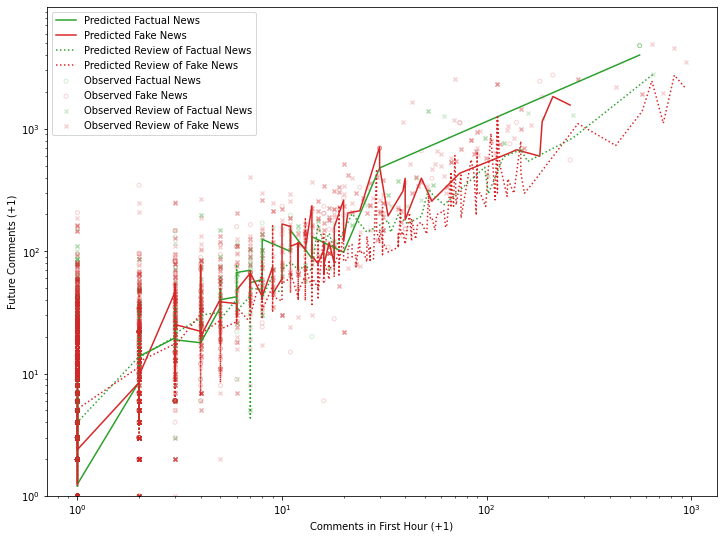

In [25]:
y_pred = mm.get_y_pred(use_train=True)
plot_predictions(mm.y_train, mm.original_p_data_train, mm.p_types_train, y_pred, filename="complete_predictions.png")

For 1% more comments in 1st, hour, we'd see just under 1% more future comments.

In [26]:
print_labeled_type_coefs(mm.p_types, mm.p_stories, mm.p_subreddits, mm.t_data, mm.s_data, mm.r_data)

log 1st Hour Comments Coefficient for Type:
	Factual News: 1.03
	Fake News: 0.998
	Review of Factual News: 0.996
	Review of Fake News: 0.914


In [27]:
posterior_predictive_samples = mm.get_samples("complete", zero_inflated=True, num_samples=100)

Now, we see much broader bands in the HDI plot, covering more of our observations. This could be a good sign, as the output of our model looks more like the observed distribution, but it also may allow our model to make predictions that are less likely.

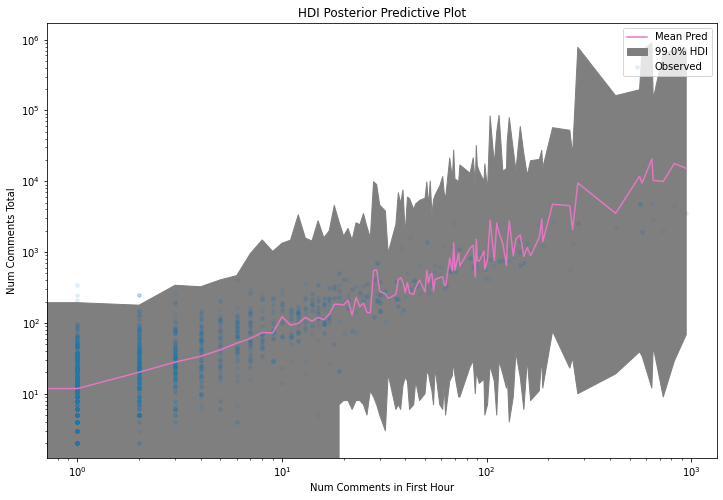

In [28]:
plot_pp_hdi(posterior_predictive_samples, mm.original_p_data_train, mm.y_train, filename="complete_hdi.png")

In the PPCs, despite the broader HDI bands, the observed statistics still seem to align with the statistics of the posterior predictive distributions generated from the training data. Again, we still struggle with overestimation of variance.

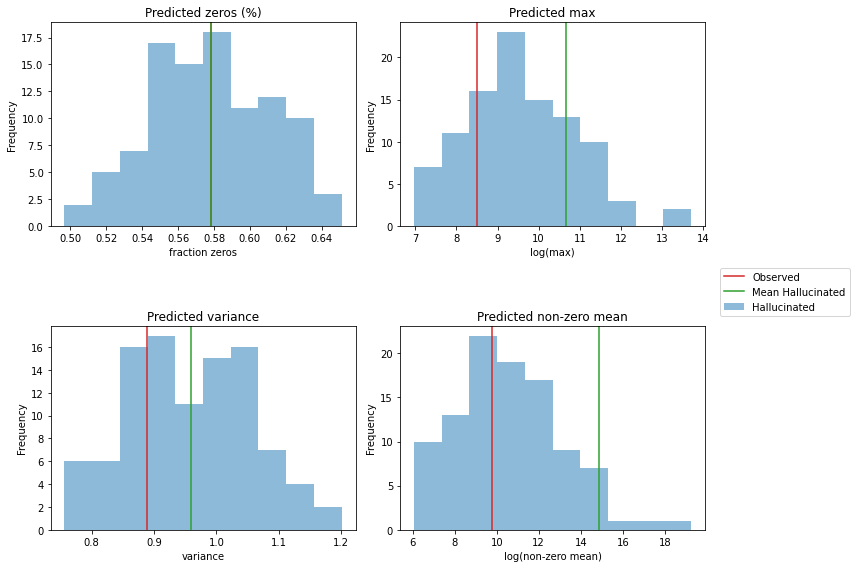

In [29]:
plot_ppc_grid(posterior_predictive_samples, mm.y_train, filename="complete_ppc.png")

In [30]:
mm.evaluate(y_pred, partition='train', model='complete')
print_results(mm.results, partition='train')

                    type    subreddit    complete
----------------  ------  -----------  ----------
R^2                 0.72         0.76        0.77
R^2 log non-zero    0.31         0.47        0.55


In [31]:
y_pred = mm.get_y_pred(use_train=False)
mm.evaluate(y_pred, partition='test', model='complete')

---

# Conclusion

In [32]:
print_results(mm.results, partition="train")

                    type    subreddit    complete
----------------  ------  -----------  ----------
R^2                 0.72         0.76        0.77
R^2 log non-zero    0.31         0.47        0.55


In [33]:
print_results(mm.results, partition="test")

                    type    subreddit    complete
----------------  ------  -----------  ----------
R^2                 0.32         0.64        0.45
R^2 log non-zero    0.33         0.48        0.55


---

# References

- Zhang, J., Carpenter, D., & Ko, M. (2013). Online astroturfing: A theoretical perspective.

---